In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import random
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, IterableDataset
import PIL 
from tqdm import tqdm
import matplotlib.pyplot as plt
# tsne and pca
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import untils
from DeepTaxonNet import DeepTaxonNet
import argparse
import utils

from sklearn.mixture import GaussianMixture

import os
import sys

from collections import defaultdict
import time # For timing initialization
import warnings # For clearer warnings
import random

In [3]:
train_loader, test_loader, train_set, test_set = utils.get_data_loader('omniglot', 128, False)

/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Create Episodic Sampler for Omniglot

In [6]:
class EpisodeDataset(IterableDataset):
    """
    Generates batches for N-way K-shot classification tasks using PyTorch IterableDataset.

    Each batch corresponds to a single few-shot task (episode).
    It samples N classes, then K support examples and Q query examples for each class.

    Designed to work with a standard PyTorch Dataset that returns (image, label) tuples.
    """
    def __init__(self, dataset, class_list, n_way, k_shot, n_query, n_episodes_per_epoch):
        """
        Initializes the EpisodeDataset.

        Args:
            dataset (torch.utils.data.Dataset): The underlying dataset.
                                                 Expected: dataset[i] returns (image_tensor, class_label).
                                                 Optimization: Can optionally have `dataset.class_indices`
                                                 (dict: class -> [indices]) and `dataset.get_label(index)`
                                                 for faster initialization.
            class_list (iterable): A list or set of unique class labels to sample episodes from
                                   (e.g., training classes or test classes for this specific sampler).
            n_way (int): Number of classes per episode (N).
            k_shot (int): Number of support examples per class (K).
            n_query (int): Number of query examples per class (Q).
            n_episodes_per_epoch (int): How many episodes (batches) to generate per epoch.
        """
        super().__init__()

        # --- 1. Input Validation ---
        if not isinstance(dataset, torch.utils.data.Dataset):
            raise TypeError("`dataset` must be a PyTorch Dataset object.")
        if not hasattr(class_list, '__iter__'):
            raise TypeError("`class_list` must be an iterable (list, set, etc.).")
        if not (isinstance(n_way, int) and n_way > 0):
            raise ValueError("`n_way` must be a positive integer.")
        if not (isinstance(k_shot, int) and k_shot > 0):
            raise ValueError("`k_shot` must be a positive integer.")
        if not (isinstance(n_query, int) and n_query >= 0): # Query set can be empty
            raise ValueError("`n_query` must be a non-negative integer.")
        if not (isinstance(n_episodes_per_epoch, int) and n_episodes_per_epoch > 0):
            raise ValueError("`n_episodes_per_epoch` must be a positive integer.")

        self.dataset = dataset
        # Store unique, sorted list of classes relevant for this sampler
        self.available_classes = sorted(list(set(class_list)))
        self.n_way = n_way
        self.k_shot = k_shot
        self.n_query = n_query
        self.n_episodes_per_epoch = n_episodes_per_epoch
        self.samples_per_class_needed = self.k_shot + self.n_query

        if self.samples_per_class_needed <= 0:
             raise ValueError("k_shot + n_query must be > 0")

        # --- 2. Indexing: Map classes to their sample indices ---
        start_time = time.time()
        print("Initializing EpisodeDataset: Indexing dataset by class...")
        # This dictionary will store: {class_label: [list of indices in self.dataset]}
        self.class_to_indices = defaultdict(list)
        self._build_class_indices() # Helper method for clarity
        indexing_time = time.time() - start_time
        print(f"-> Indexing complete in {indexing_time:.2f} seconds.")
        print(f"-> Found {len(self.class_to_indices)} classes with enough samples.")

        # --- 3. Final Validation ---
        # Update available_classes based on indexing results
        self.available_classes = sorted(list(self.class_to_indices.keys()))

        if len(self.available_classes) < self.n_way:
            raise ValueError(
                f"Not enough classes with sufficient samples found. "
                f"Need {self.n_way} classes for N-way sampling, but only found "
                f"{len(self.available_classes)} classes with at least "
                f"{self.samples_per_class_needed} samples in the provided class_list."
            )

        print(f"EpisodeDataset ready: Using {len(self.available_classes)} classes for {self.n_way}-way {self.k_shot}-shot tasks "
              f"({self.n_query} query samples/class).")
        print(f"Generating {self.n_episodes_per_epoch} episodes per epoch.")

    def _build_class_indices(self):
        """
        Populates self.class_to_indices by mapping class labels to their
        corresponding indices in the underlying dataset.
        Filters classes based on the required number of samples (k_shot + n_query).
        """
        valid_class_count = 0

        # OPTIMIZATION: Check if the dataset object already provides pre-computed indices
        if hasattr(self.dataset, 'class_indices') and isinstance(self.dataset.class_indices, dict):
            print("--> Attempting to use precomputed `class_indices` from dataset.")
            found_precomputed = True
            # Iterate through the classes relevant for *this* sampler instance
            for cls_label in self.available_classes:
                if cls_label in self.dataset.class_indices:
                    indices = self.dataset.class_indices[cls_label]
                    # Check if this class has enough samples
                    if len(indices) >= self.samples_per_class_needed:
                        self.class_to_indices[cls_label] = indices
                        valid_class_count += 1
                    else:
                        warnings.warn(f"Class '{cls_label}' found in precomputed indices but has only "
                                      f"{len(indices)} samples (need {self.samples_per_class_needed}). Skipping.")
                else:
                    warnings.warn(f"Class '{cls_label}' from class_list not found in dataset.class_indices.")
            if valid_class_count > 0:
                 print(f"--> Successfully used precomputed indices for {valid_class_count} classes.")
                 return # Successfully used precomputed indices

            else:
                 print("--> Precomputed indices found but none were suitable/matched class_list. Falling back to manual indexing.")


        # FALLBACK: Manually iterate through the dataset if precomputed indices aren't suitable/available
        print("--> Manually indexing dataset by class (can be slow for large datasets)...")
        has_get_label = hasattr(self.dataset, 'get_label') and callable(self.dataset.get_label)
        if not has_get_label:
            print("    (Dataset lacks `get_label` method, will load items via __getitem__ for indexing)")

        temp_indices = defaultdict(list)
        dataset_len = len(self.dataset)
        class_list_set = set(self.available_classes) # Use set for faster lookups

        for i in range(dataset_len):
            try:
                # Get label: Use get_label if available (faster), otherwise load item
                if has_get_label:
                    label = self.dataset.get_label(i)
                else:
                    _, label = self.dataset[i] # Slower: loads image data too

                # Ensure label is a hashable type (e.g., int, string)
                if isinstance(label, torch.Tensor): label = label.item()
                elif isinstance(label, np.ndarray): label = label.item()

                # Store index if the label is in the list for this sampler
                if label in class_list_set:
                    temp_indices[label].append(i)

                # Optional: Progress indicator for very large datasets
                # if (i + 1) % 20000 == 0: print(f"    Indexed {i+1}/{dataset_len}...")

            except Exception as e:
                warnings.warn(f"Could not process index {i} during manual indexing. Error: {e}")
                continue

        # Filter the manually collected indices based on sample count
        for cls_label, indices in temp_indices.items():
            if len(indices) >= self.samples_per_class_needed:
                self.class_to_indices[cls_label] = indices
                valid_class_count += 1
            else:
                 warnings.warn(f"Class '{cls_label}' found via manual indexing but has only "
                               f"{len(indices)} samples (need {self.samples_per_class_needed}). Skipping.")
        print(f"--> Manual indexing complete. Found {valid_class_count} valid classes.")


    def __iter__(self):
        """
        Yields episode batches for one epoch.
        """
        episode_count = 0
        while episode_count < self.n_episodes_per_epoch:

            # --- 1. Sample N distinct classes for the episode ---
            try:
                # Randomly select N classes from the list of classes that have enough samples
                episode_class_labels = random.sample(self.available_classes, self.n_way)
            except ValueError:
                # This should only happen if self.available_classes < self.n_way,
                # which is checked in __init__, but included as a safeguard.
                warnings.warn(f"Could not sample {self.n_way} classes from {len(self.available_classes)} available classes. Stopping iteration.")
                break # Stop the generator

            support_indices = []
            query_indices = []
            support_local_labels_list = []
            query_local_labels_list = []

            # --- 2. Sample K support and Q query examples for each chosen class ---
            sampling_successful = True
            for local_label_idx, global_class_label in enumerate(episode_class_labels):
                all_indices_for_class = self.class_to_indices[global_class_label]
                num_available = len(all_indices_for_class)

                # Double-check sample count (should be guaranteed by __init__)
                if num_available < self.samples_per_class_needed:
                     warnings.warn(f"Class '{global_class_label}' unexpectedly found with insufficient samples ({num_available}) during iteration. Skipping episode.")
                     sampling_successful = False
                     break # Skip this episode

                # Efficiently sample K+Q indices without replacement
                # torch.randperm is faster than random.sample for integer ranges
                shuffled_local_indices = torch.randperm(num_available)
                selected_local_indices = shuffled_local_indices[:self.samples_per_class_needed]
                # Map these back to the actual dataset indices
                selected_global_indices = [all_indices_for_class[i.item()] for i in selected_local_indices]

                # Split into support and query sets
                class_support_indices = selected_global_indices[:self.k_shot]
                class_query_indices = selected_global_indices[self.k_shot:]

                support_indices.extend(class_support_indices)
                query_indices.extend(class_query_indices)

                # Assign the *local* episode label (0 to N-1) corresponding to this class
                support_local_labels_list.extend([local_label_idx] * self.k_shot)
                query_local_labels_list.extend([local_label_idx] * self.n_query)

            # If sampling failed for any class in this episode, skip to the next iteration
            if not sampling_successful:
                continue

            # --- 3. Fetch the actual data (images) using the sampled indices ---
            try:
                # This step involves accessing self.dataset[idx], which might be slow if loading from disk.
                support_items = [self.dataset[idx] for idx in support_indices] # List of (img, label) tuples
                query_items = [self.dataset[idx] for idx in query_indices]     # List of (img, label) tuples
            except Exception as e:
                warnings.warn(f"Error fetching data for episode (indices: S={support_indices}, Q={query_indices}). Error: {e}. Skipping episode.")
                continue # Skip this episode

            # --- 4. Format the batch: Stack images and create label tensors ---
            try:
                # Assuming the first element of the item tuple is the image tensor
                support_images = torch.stack([item[0] for item in support_items]) # Shape: (N*K, C, H, W)
                query_images = torch.stack([item[0] for item in query_items])     # Shape: (N*Q, C, H, W)

                # Convert the local label lists (0 to N-1) to tensors
                support_local_labels = torch.tensor(support_local_labels_list, dtype=torch.long) # Shape: (N*K)
                query_local_labels = torch.tensor(query_local_labels_list, dtype=torch.long)     # Shape: (N*Q)

            except Exception as e:
                 warnings.warn(f"Error stacking tensors or creating label tensors. Error: {e}. Skipping episode.")
                 # You might want to inspect item[0].shape and type here if errors occur
                 continue # Skip this episode

            # --- 5. Yield the complete episode batch ---
            yield {
                'support_images': support_images,       # Images for the support set
                'support_labels': support_local_labels, # Corresponding local labels (0 to N-1)
                'query_images': query_images,           # Images for the query set
                'query_labels': query_local_labels,     # Corresponding local labels (0 to N-1)
                'episode_classes': episode_class_labels # Original class labels used in this episode (optional)
            }
            episode_count += 1 # Increment count only after successfully yielding an episode


    def __len__(self):
        """
        Returns the number of episodes intended to be generated per epoch.
        Note: For IterableDataset, this is often informational. The iteration stops
              based on the logic within __iter__.
        """
        return self.n_episodes_per_epoch

In [13]:
# --- Assuming you have your test_base_dataset prepared ---
# Example: test_base_dataset = YourOmniglotDataset(split='test', ...)

# --- Also assume EpisodeDataset class definition is available ---
# from your_module import EpisodeDataset # Or paste the class definition

# Define test episode parameters
N_WAY_TEST = 5
K_SHOT_TEST = 1
N_QUERY_TEST = 5
N_TEST_EPISODES = 10 # Number of test episodes to evaluate on

# Get the list of unique classes present in the test dataset
# This assumes your test_base_dataset has a way to get all its unique labels,
# or you know them beforehand.
# Example: test_classes = list(test_base_dataset.class_indices.keys())
# Or if you don't have class_indices:
test_classes = sorted(list(set(label for _, label in test_set)))


# Create the EpisodeDataset specifically for testing
test_episode_dataset = EpisodeDataset(
    dataset=test_set,
    class_list=test_classes,
    n_way=N_WAY_TEST,
    k_shot=K_SHOT_TEST,
    n_query=N_QUERY_TEST,
    n_episodes_per_epoch=N_TEST_EPISODES # Generate enough episodes for evaluation
)

# Create the DataLoader for testing (note batch_size=None)
test_loader = DataLoader(
    dataset=test_episode_dataset,
    batch_size=None, # EpisodeDataset yields full episodes as batches
    num_workers=0 # Often safer for IterableDatasets, adjust if needed
)

# Example of iterating through the testing loader
# for test_episode_batch in test_loader:
#     # Your N-way K-shot testing/evaluation logic here
#     # Access data like:
#     # support_images = test_episode_batch['support_images']
#     # support_labels = test_episode_batch['support_labels'] (local 0 to N-1)
#     # query_images = test_episode_batch['query_images']
#     # query_labels = test_episode_batch['query_labels'] (local 0 to N-1)
#     pass

Initializing EpisodeDataset: Indexing dataset by class...
--> Manually indexing dataset by class (can be slow for large datasets)...
    (Dataset lacks `get_label` method, will load items via __getitem__ for indexing)
--> Manual indexing complete. Found 659 valid classes.
-> Indexing complete in 7.05 seconds.
-> Found 659 classes with enough samples.
EpisodeDataset ready: Using 659 classes for 5-way 1-shot tasks (5 query samples/class).
Generating 10 episodes per epoch.


In [21]:
for test_episode_batch in test_loader:
    # print(test_episode_batch)
    print("Test Episode Batch:")
    print("Support Images Shape:", test_episode_batch['support_images'].shape)
    print("Support Labels Shape:", test_episode_batch['support_labels'])
    print("Query Images Shape:", test_episode_batch['query_images'].shape)
    print("Query Labels Shape:", test_episode_batch['query_labels'])
    break

Test Episode Batch:
Support Images Shape: torch.Size([5, 1, 28, 28])
Support Labels Shape: tensor([0, 1, 2, 3, 4])
Query Images Shape: torch.Size([25, 1, 28, 28])
Query Labels Shape: tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4])


In [2]:
train_loader, test_loader, train_set, test_set = utils.get_data_loader('omniglot', 128, False,
                                                                       N_WAY_TEST=5,
                                                                       K_SHOT_TEST=1,
                                                                       N_QUERY_TEST=15,
                                                                       N_TEST_EPISODES=600)

Initializing EpisodeDataset: Indexing dataset by class...
--> Manually indexing dataset by class (can be slow for large datasets)...
    (Dataset lacks `get_label` method, will load items via __getitem__ for indexing)
--> Manual indexing complete. Found 659 valid classes.
-> Indexing complete in 7.04 seconds.
-> Found 659 classes with enough samples.
EpisodeDataset ready: Using 659 classes for 5-way 1-shot tasks (15 query samples/class).
Generating 600 episodes per epoch.


/nethome/zwang910/miniconda3/envs/dl/lib/python3.13/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [3]:
import math

def visualize_episode(test_loader, n_way, k_shot, n_query):
    """
    Fetches one episode from the test_loader and visualizes its
    support and query sets.

    Args:
        test_loader (DataLoader): The DataLoader yielding test episodes.
        n_way (int): Number of classes per episode.
        k_shot (int): Number of support examples per class.
        n_query (int): Number of query examples per class.
    """
    try:
        print("Fetching one episode batch from the test loader...")
        # Get a single batch (which is one episode)
        episode_batch = next(iter(test_loader))
        print("Batch fetched successfully.")

    except StopIteration:
        print("Error: The test loader is empty or exhausted.")
        return
    except Exception as e:
        print(f"An error occurred while fetching the batch: {e}")
        return

    # Extract data from the batch
    support_images = episode_batch['support_images'] # Shape: (N*K, C, H, W)
    support_labels = episode_batch['support_labels'] # Shape: (N*K)
    query_images = episode_batch['query_images']     # Shape: (N*Q, C, H, W)
    query_labels = episode_batch['query_labels']     # Shape: (N*Q)
    episode_classes = episode_batch.get('episode_classes', None) # Optional: Original classes

    print(f"\n--- Episode Details ---")
    print(f"Support Set Size: {support_images.shape[0]} images ({n_way} classes x {k_shot} shot)")
    print(f"Query Set Size: {query_images.shape[0]} images ({n_way} classes x {n_query} query)")
    if episode_classes:
        print(f"True Classes in Episode: {episode_classes}")
    print("-" * 25)


    # --- Prepare for Plotting ---
    num_support_images = support_images.shape[0]
    num_query_images = query_images.shape[0]

    # Determine grid size (try to make it somewhat square)
    total_images = num_support_images + num_query_images
    # Calculate rows needed, placing support and query sets separately
    support_rows = math.ceil(num_support_images / n_way) if n_way > 0 else 0
    query_rows = math.ceil(num_query_images / n_way) if n_way > 0 else 0
    total_rows = support_rows + query_rows + (1 if support_rows > 0 and query_rows > 0 else 0) # Add spacer row if both exist
    cols = n_way # Arrange images by class column

    if total_rows == 0 or cols == 0:
        print("Error: Cannot plot with zero support or query images.")
        return

    fig, axes = plt.subplots(total_rows, cols, figsize=(cols * 2, total_rows * 2.5))
    # Adjust figsize as needed

    # Flatten axes array for easier indexing if it's multi-dimensional
    if total_rows > 1 or cols > 1:
        axes = axes.ravel()
    else: # Handle case of single subplot
        axes = [axes]

    plot_idx = 0 # Keep track of the current subplot index

    # --- Plot Support Set ---
    fig.suptitle("Sample Test Episode Visualization", fontsize=16, y=1.02) # Overall title

    if num_support_images > 0:
        print("Plotting Support Set...")
        # Add a title for the support set section
        # Place title spanning columns in the first row
        ax_span = fig.add_subplot(total_rows, 1, 1) # Span across columns for title
        ax_span.set_title(f"Support Set ({k_shot}-shot)", fontsize=14, pad=20)
        ax_span.axis('off') # Hide the axes for the title span

        # Plot support images starting from the second visual row (index 1)
        support_start_row_idx = 1 if support_rows > 0 else 0
        plot_idx = support_start_row_idx * cols # Start plotting index after title row

        for i in range(num_support_images):
            if plot_idx >= len(axes): break # Safety break
            ax = axes[plot_idx]
            img = support_images[i]
            label = support_labels[i].item() # Get the local label (0 to N-1)

            # Move tensor to CPU and detach from graph
            img = img.cpu().detach()

            # Handle image channels for plotting
            if img.shape[0] == 1: # Grayscale image (C=1)
                img_display = img.squeeze(0).numpy() # Shape: (H, W)
                cmap = 'gray'
            elif img.shape[0] == 3: # RGB image (C=3)
                img_display = img.permute(1, 2, 0).numpy() # Shape: (H, W, C)
                cmap = None # Use default colormap for RGB
                # Note: If images were normalized, colors might look odd.
                # Consider adding denormalization if needed for better visuals.
            else: # Unexpected channel size
                 print(f"Warning: Image {i} has unexpected channel size {img.shape[0]}. Skipping display.")
                 img_display = np.zeros((img.shape[1], img.shape[2])) # Placeholder
                 cmap = 'gray'


            ax.imshow(img_display, cmap=cmap)
            ax.set_title(f"Support: Cls {label}") # Show local class label
            ax.axis('off') # Hide axes ticks
            plot_idx += 1

        # Fill remaining axes in support rows if any
        while plot_idx < (support_start_row_idx + support_rows) * cols and plot_idx < len(axes):
             axes[plot_idx].axis('off')
             plot_idx +=1

    # --- Plot Query Set ---
    if num_query_images > 0:
        print("Plotting Query Set...")
         # Add a title for the query set section
        query_title_row_idx = support_rows + (1 if support_rows > 0 else 0)
        ax_span_q = fig.add_subplot(total_rows, 1, query_title_row_idx + 1) # Span across columns
        ax_span_q.set_title(f"Query Set (True Labels)", fontsize=14, pad=20)
        ax_span_q.axis('off')

        # Start plotting query images after the support rows and title row
        query_start_row_idx = query_title_row_idx + 1
        plot_idx = query_start_row_idx * cols # Start plotting index

        for i in range(num_query_images):
            if plot_idx >= len(axes): break # Safety break
            ax = axes[plot_idx]
            img = query_images[i]
            label = query_labels[i].item() # Get the local label (0 to N-1)

            # Move tensor to CPU and detach
            img = img.cpu().detach()

            # Handle image channels
            if img.shape[0] == 1:
                img_display = img.squeeze(0).numpy()
                cmap = 'gray'
            elif img.shape[0] == 3:
                img_display = img.permute(1, 2, 0).numpy()
                cmap = None
            else:
                 print(f"Warning: Query Image {i} has unexpected channel size {img.shape[0]}. Skipping display.")
                 img_display = np.zeros((img.shape[1], img.shape[2])) # Placeholder
                 cmap = 'gray'

            ax.imshow(img_display, cmap=cmap)
            ax.set_title(f"Query: Cls {label}") # Show local class label
            ax.axis('off')
            plot_idx += 1

        # Fill remaining axes if any
        while plot_idx < len(axes):
             axes[plot_idx].axis('off')
             plot_idx +=1


    # --- Display Plot ---
    plt.tight_layout(rect=[0, 0.03, 1, 0.98]) # Adjust layout to prevent overlap, leave space for suptitle
    plt.show()


Fetching one episode batch from the test loader...
Batch fetched successfully.

--- Episode Details ---
Support Set Size: 5 images (5 classes x 1 shot)
Query Set Size: 75 images (5 classes x 15 query)
True Classes in Episode: [61, 454, 337, 633, 84]
-------------------------
Plotting Support Set...
Plotting Query Set...


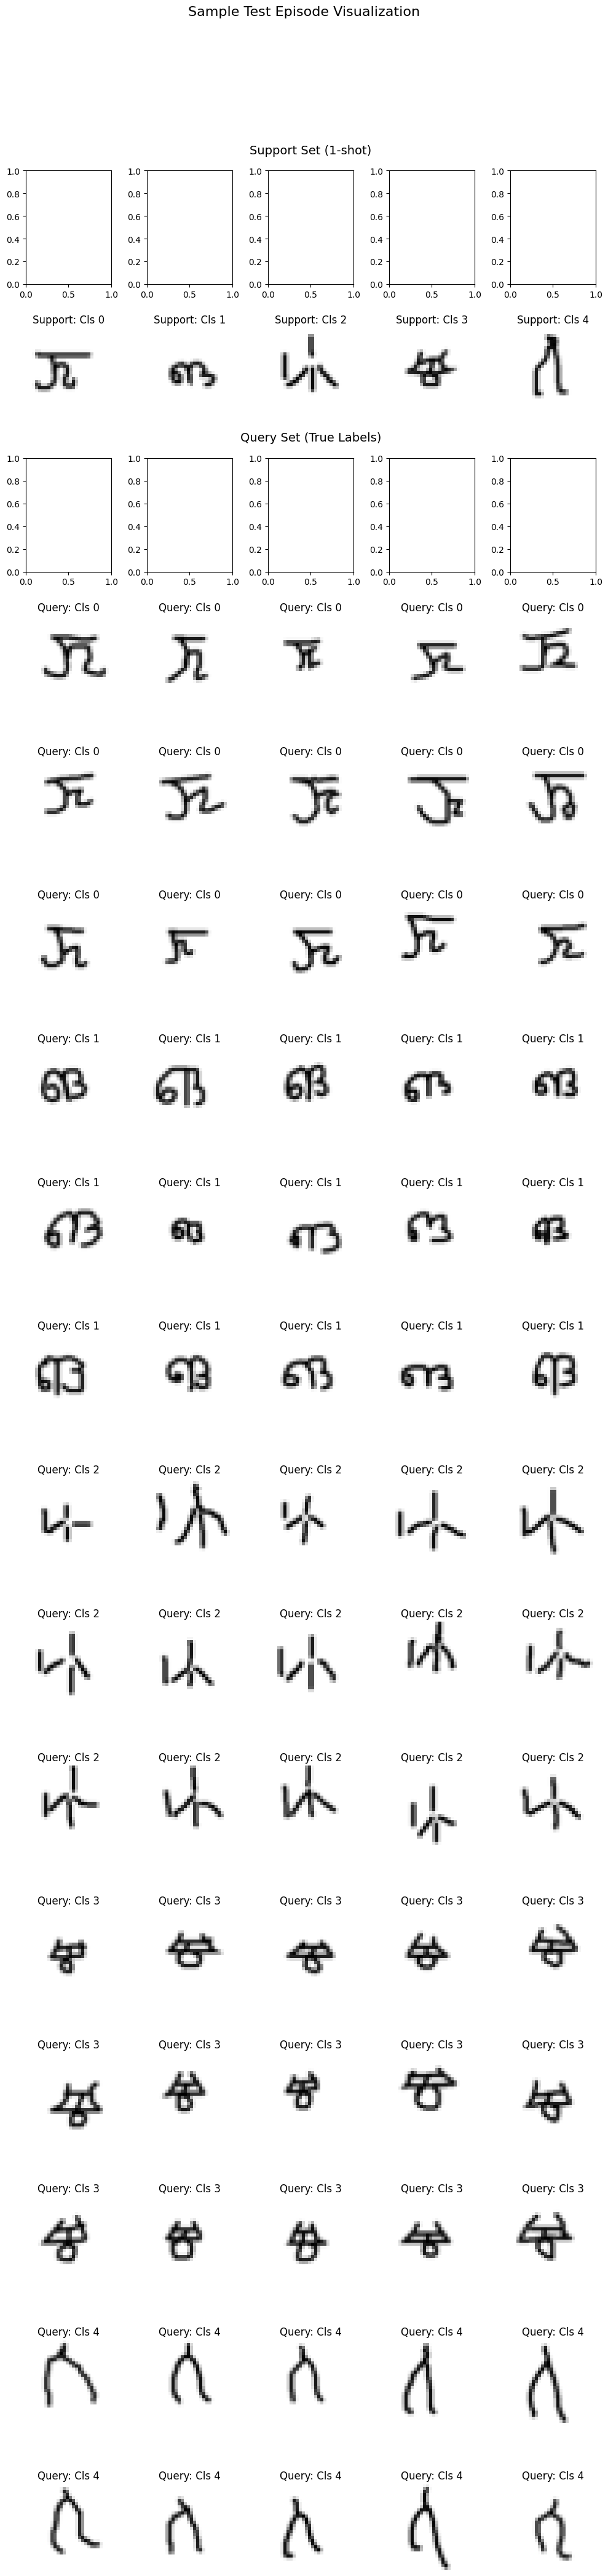

In [5]:
visualize_episode(test_loader, 5, 1, 15)
